### features:
* spectogram coef
* zero crossing rate
* selected chromogram values
* selected tempogram values
* wavelet levels

In [1]:
import pandas as pd 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
import itertools

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
path = "/Users/ecem/Desktop/phonocardiogram/data/TV"

## Load data

Here, our target is to predict disease of patients with multiple diseases. So; our y will be disease column of two column indicatin geach patients disease.

In [3]:
present_df = pd.read_csv(path + "/present/present_TV_p_features.csv", index_col = 0) #1205, 18864
#present_df

,freq_0,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_7,freq_8,freq_9,...,tempogram_177,tempogram_179,tempogram_180,tempogram_181,tempogram_182,tempogram_183,tempogram_184,tempogram_189,tempogram_190,tempogram_191
0,1.026805e-10,1.455476e-10,1.463834e-10,1.475064e-10,1.487800e-10,1.501075e-10,1.514032e-10,1.525765e-10,1.535278e-10,1.541567e-10,...,6.142580e-18,9.206074e-18,1.457822e-17,2.013753e-17,3.634786e-19,1.243471e-17,1.105080e-17,1.705985e-17,1.623126e-17,1.937348e-17
1,6.263979e-11,8.875031e-11,8.917864e-11,8.975639e-11,9.039855e-11,9.107238e-11,9.182894e-11,9.282966e-11,9.409163e-11,9.545127e-11,...,-8.846758e-18,4.404975e-18,1.170317e-17,2.177864e-17,-4.898098e-18,2.487981e-18,2.040043e-18,4.309049e-18,9.520506e-18,1.174371e-17
2,9.586826e-11,1.356420e-10,1.358406e-10,1.365911e-10,1.380753e-10,1.397104e-10,1.412548e-10,1.425729e-10,1.435720e-10,1.441930e-10,...,-1.223748e-17,9.736586e-18,1.568854e-17,3.521199e-17,-3.896177e-18,1.375557e-17,1.991244e-17,1.523117e-17,1.129922e-17,2.816323e-17
3,8.224721e-11,1.182147e-10,1.213804e-10,1.245988e-10,1.282398e-10,1.326121e-10,1.367849e-10,1.405585e-10,1.438477e-10,1.466254e-10,...,9.750855e-19,3.365173e-18,1.222500e-17,2.261293e-17,3.139270e-18,5.725922e-18,9.587301e-18,9.928566e-18,7.236449e-18,1.649091e-17
4,1.524600e-10,2.223175e-10,2.397989e-10,2.636897e-10,2.906240e-10,3.184967e-10,3.460145e-10,3.723675e-10,3.970771e-10,4.198234e-10,...,-4.292943e-18,-1.595370e-18,-3.309437e-19,7.464136e-18,-5.164900e-18,1.546850e-18,4.775294e-18,-2.266250e-18,-2.416256e-18,4.154944e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,4.123272e-10,5.937346e-10,6.189569e-10,6.506925e-10,6.842032e-10,7.164136e-10,7.453172e-10,7.697093e-10,7.888630e-10,8.024662e-10,...,-9.485070e-18,4.281932e-18,7.076818e-18,1.469780e-17,-6.843115e-18,-5.032860e-18,-7.215422e-18,5.673748e-18,3.168160e-18,1.243066e-17
1201,3.631233e-10,5.210558e-10,5.403737e-10,5.664170e-10,5.951361e-10,6.234697e-10,6.486631e-10,6.680131e-10,6.791120e-10,6.806829e-10,...,-2.634732e-18,8.318904e-19,6.103234e-18,1.389794e-17,-4.978813e-18,-7.155129e-18,-7.842521e-18,5.734599e-20,5.143600e-18,1.318682e-17
1202,3.619796e-10,5.207971e-10,5.358179e-10,5.477964e-10,5.552154e-10,5.588938e-10,5.608351e-10,5.632281e-10,5.668889e-10,5.831663e-10,...,-4.803635e-18,4.515858e-18,8.239047e-18,2.076973e-17,-1.066834e-17,2.508574e-18,4.619068e-18,1.182112e-17,4.959020e-18,1.678453e-17
1203,5.244571e-10,7.520905e-10,7.652491e-10,7.770539e-10,7.867998e-10,7.942848e-10,7.995894e-10,8.030440e-10,8.043440e-10,8.022694e-10,...,-8.494817e-18,2.511972e-17,2.521040e-17,4.377844e-17,-1.689769e-18,1.233342e-17,1.912012e-17,1.492043e-17,1.535483e-17,3.714003e-17


In [5]:
absent_df = pd.read_csv(path + "/absent/absent_TV_p_features.csv", index_col = 0) #5718, 18864
#absent_df

,freq_0,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_7,freq_8,freq_9,...,tempogram_177,tempogram_179,tempogram_180,tempogram_181,tempogram_182,tempogram_183,tempogram_184,tempogram_189,tempogram_190,tempogram_191
0,1.250422e-10,1.770957e-10,1.777668e-10,1.786233e-10,1.794487e-10,1.800744e-10,1.803611e-10,1.801847e-10,1.794445e-10,1.780774e-10,...,-6.905134e-19,2.754567e-18,7.773941e-18,1.988957e-17,-6.559933e-18,1.320242e-17,2.091703e-17,1.325707e-17,8.650075e-18,1.822175e-17
1,1.264575e-10,1.795607e-10,1.812976e-10,1.833913e-10,1.852988e-10,1.865859e-10,1.869524e-10,1.862651e-10,1.845937e-10,1.822535e-10,...,-1.133324e-17,-7.011557e-19,4.974645e-18,1.588862e-17,-1.125853e-17,2.416476e-18,7.882053e-18,5.798473e-18,2.658724e-18,1.184895e-17
2,1.587999e-10,2.247442e-10,2.249352e-10,2.249325e-10,2.247001e-10,2.242679e-10,2.236984e-10,2.230695e-10,2.224654e-10,2.219678e-10,...,6.554084e-19,1.849737e-17,2.810480e-17,3.769837e-17,7.925154e-18,2.082067e-17,1.904633e-17,1.664006e-17,1.955164e-17,3.412907e-17
3,1.685973e-10,2.381791e-10,2.367048e-10,2.338837e-10,2.298246e-10,2.247923e-10,2.192171e-10,2.141382e-10,2.104244e-10,2.079975e-10,...,2.497383e-18,7.790100e-18,2.094238e-17,3.463378e-17,2.906330e-18,9.115455e-18,8.385252e-18,1.484120e-17,1.352497e-17,2.611679e-17
4,6.277384e-11,9.231368e-11,9.650064e-11,1.005693e-10,1.043453e-10,1.076791e-10,1.104635e-10,1.126726e-10,1.144780e-10,1.163416e-10,...,6.587288e-18,-2.589707e-18,9.884369e-18,1.785495e-17,-3.576953e-18,9.165434e-18,7.877348e-18,5.050585e-18,8.566194e-18,1.400716e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5713,4.651500e-11,6.568135e-11,6.514680e-11,6.405509e-11,6.249095e-11,6.082637e-11,5.999792e-11,6.004364e-11,6.041054e-11,6.094395e-11,...,-6.931130e-18,7.194039e-18,1.329091e-17,2.528681e-17,7.204028e-18,1.282246e-17,1.294304e-17,1.094786e-17,8.543689e-18,1.970585e-17
5714,2.818320e-11,4.115034e-11,4.440116e-11,4.863238e-11,5.315281e-11,5.752565e-11,6.148158e-11,6.486935e-11,6.763484e-11,6.982312e-11,...,3.546355e-18,1.135772e-17,2.223558e-17,4.014005e-17,4.893794e-18,1.773325e-17,2.272166e-17,1.970576e-17,1.617390e-17,3.092599e-17
5715,4.370207e-11,6.265694e-11,6.383275e-11,6.466049e-11,6.495511e-11,6.471965e-11,6.412391e-11,6.324165e-11,6.202234e-11,6.050815e-11,...,-8.692988e-18,5.517997e-18,1.577758e-17,3.027850e-17,-2.192866e-18,6.213007e-18,1.329542e-17,1.421307e-17,8.164764e-18,1.845018e-17
5716,5.302483e-11,7.451274e-11,7.310148e-11,7.081104e-11,6.774836e-11,6.408586e-11,6.007476e-11,5.606041e-11,5.251604e-11,5.007570e-11,...,-9.247145e-19,6.588061e-18,1.171707e-17,2.554449e-17,-1.190361e-17,-7.311243e-19,7.245004e-18,6.586537e-18,5.038690e-18,2.489747e-17


### create labels

In [6]:
y = np.concatenate((np.ones(1205), np.zeros(5718)), axis =0)
y.shape

(6923,)

## concat features

In [8]:
df = pd.concat([present_df, absent_df], axis = 0) #6923, 18864
#df

## With threshold

In [9]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold =  0.0001)   # düşük  threshold
_ = vt.fit(df)
masked = vt.get_support()
features_masked = df.loc[:, masked]
#features_masked # uncomment to see the dataframe #6941, 703

In [10]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(features_masked, y , train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [11]:
import xgboost as xgb

clf = xgb.XGBClassifier(objective= "binary:logistic", eval_metric = "logloss")


In [12]:
clf.fit(X_train_, y_train_)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [13]:
yhat = clf.predict(X_valid_)

In [14]:
yhat.shape

(1385,)

In [15]:
y_valid_.shape

(1385,)

In [16]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid_, yhat)
print("accuracy: %.2f%%" % (accuracy * 100.0))

accuracy: 83.75%


In [17]:
from sklearn.metrics import recall_score
recall = recall_score(y_valid_, yhat, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))


recall: 83.75%


In [18]:
from sklearn.metrics import precision_score
precision = precision_score(y_valid_, yhat, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

precision: 81.96%


/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


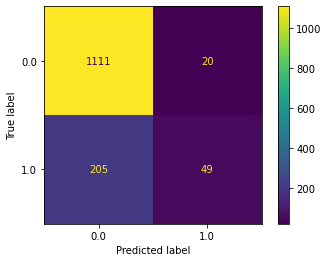

In [19]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_valid_, y_valid_) 

In [20]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_valid_, yhat)
print(f"ROC AUC: {score:.4f}")

ROC AUC: 0.5876
